In [1]:
#James Alfano
import pandas as pd
import datasets
import warnings
import sys
import numpy as np
from Preprocessing import *
from transformers import pipeline
from datasets.dataset_dict import DatasetDict
from datasets import Dataset
import transformers
import torch
from huggingface_hub import notebook_login
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer
from GPUtil import showUtilization as gpu_usage
from numba import cuda
import gc
#! pip install datasets transformers rouge-score nltk

## Reading in the Data

In [2]:
#Load the full dataset of 300k articles
#Dataset can be found here: https://huggingface.co/datasets/cnn_dailymail
dataset = datasets.load_dataset("cnn_dailymail", '3.0.0')

Found cached dataset cnn_dailymail (C:/Users/James/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [4]:
#Example article and summary
print("Example Article\n:",dataset["Train"]["Article"][0])
print("\nExample Summary\n:",dataset["Train"]["highlights"][0])

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

## Preprocessing 

In [5]:
#Take a random subset of the data
""" dataset["train"] = dataset["train"].shuffle().select(range(15000))
dataset["test"] = dataset["test"].shuffle().select(range(10000))
dataset["validation"] = dataset["validation"].shuffle().select(range(10000)) """
dataset["train"] = dataset["train"].select(range(15000))
dataset["test"] = dataset["test"].select(range(10000))
dataset["validation"] = dataset["validation"].select(range(10000))
dataset


DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 15000
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 10000
    })
})

In [6]:
#Function to preporcess the data all at once
processed_data = preprocess(dataset)

Loading cached processed dataset at C:/Users/James/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de\cache-aab7eaa6373e7804.arrow
Loading cached processed dataset at C:/Users/James/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de\cache-fdc439af218ecb92.arrow
Loading cached processed dataset at C:/Users/James/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de\cache-bc50c976f2abd0de.arrow
Loading cached processed dataset at C:/Users/James/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de\cache-87a823a0868f61d4.arrow
Loading cached processed dataset at C:/Users/James/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de\cache-a7f5f045d194085c.arrow
Loadi

In [7]:
processed_data

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 15000
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 10000
    })
})

## Inspecting the Preprocessed Data

Loading cached processed dataset at C:/Users/James/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de\cache-88225ec5dff18656.arrow
Loading cached processed dataset at C:/Users/James/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de\cache-f37d20b442852689.arrow
Loading cached processed dataset at C:/Users/James/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de\cache-5f5350f8511f177d.arrow


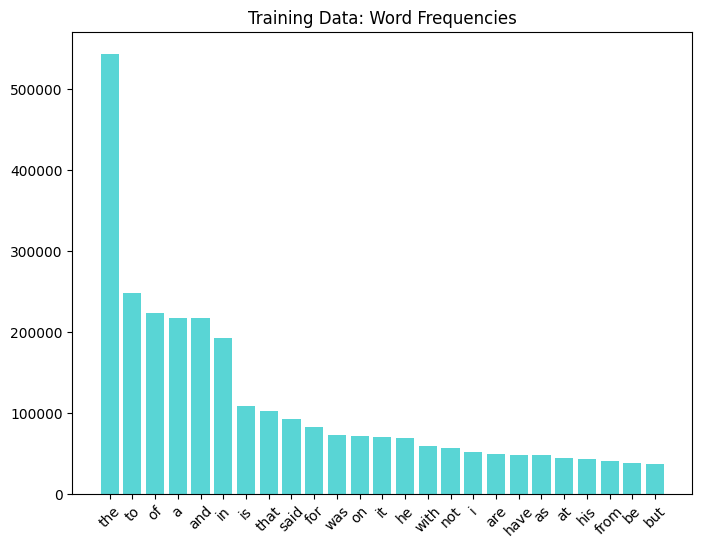

In [8]:
wrd_freq_plot(processed_data,"train", "Training Data")

Loading cached processed dataset at C:/Users/James/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de\cache-88225ec5dff18656.arrow
Loading cached processed dataset at C:/Users/James/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de\cache-f37d20b442852689.arrow
Loading cached processed dataset at C:/Users/James/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de\cache-5f5350f8511f177d.arrow


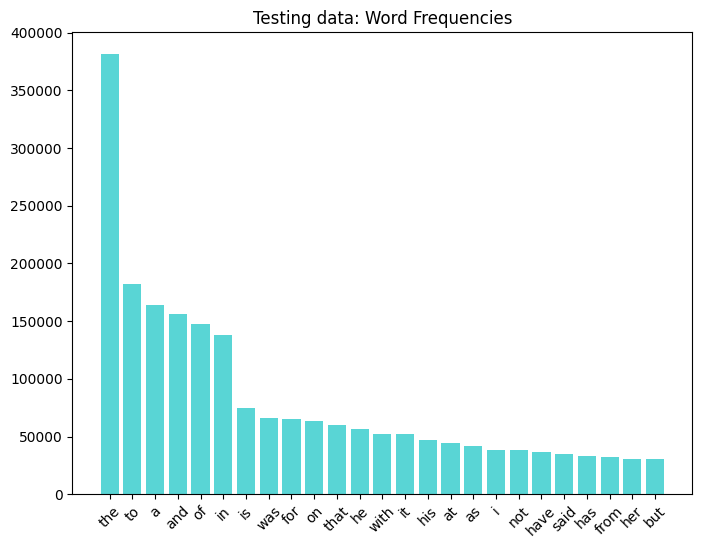

In [9]:
wrd_freq_plot(processed_data,"test", "Testing data")

Loading cached processed dataset at C:/Users/James/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de\cache-88225ec5dff18656.arrow
Loading cached processed dataset at C:/Users/James/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de\cache-f37d20b442852689.arrow
Loading cached processed dataset at C:/Users/James/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de\cache-5f5350f8511f177d.arrow


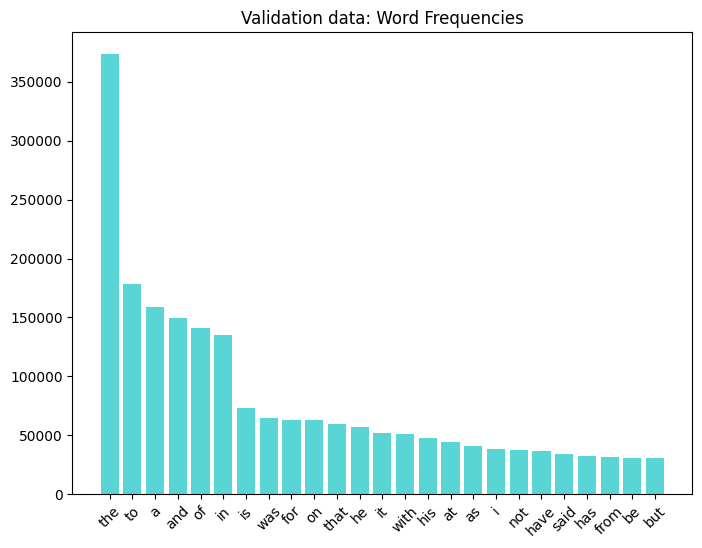

In [10]:
wrd_freq_plot(processed_data,"validation","Validation data")

In [11]:
#processed_data["train"]["article"][0]

In [12]:
#dataset["train"]["article"][0]

Loading cached processed dataset at C:/Users/James/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de\cache-88225ec5dff18656.arrow
Loading cached processed dataset at C:/Users/James/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de\cache-f37d20b442852689.arrow
Loading cached processed dataset at C:/Users/James/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de\cache-5f5350f8511f177d.arrow


The longest summary has 507 words
The longest article has 1837 words


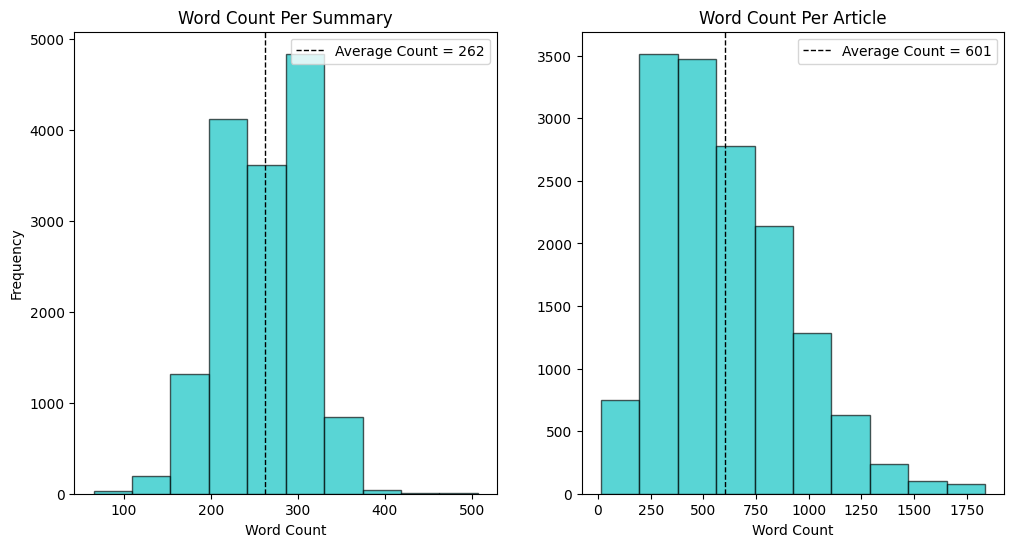

In [13]:
#Run Function to get the average word count and list of counts for all articles and summaries and plot them
avg_y, lenghts_y, avg_text, lenghts_text = plot_counts(processed_data,"train")

In [14]:
#plot_counts(processed_data,"test")

In [15]:
#plot_counts(processed_data,"validation")

## Building the Model

In [17]:
warnings.filterwarnings("ignore")
metric = load_metric("rouge")
model_checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [18]:
#Get max lenght for texts and summaries 
max_input_length = max(lenghts_text)
max_target_length = max(lenghts_y)
#max_input_length = 1000
#max_target_length = 90

def prepare_for_model(examples):
    #T5 models requires summaries of text lead with "summarize: "
    prefix = "summarize: "
    inputs = [prefix + doc for doc in examples["article"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["highlights"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [19]:
tokenized_datasets = processed_data.map(prepare_for_model, batched=True)

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [20]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 15000
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 10000
    })
})

In [22]:
tokenized_datasets["train"]["highlights"][0]

"Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .\nYoung actor says he has no plans to fritter his cash away .\nRadcliffe's earnings from first five Potter films have been held in trust fund ."

In [23]:
#The model used below requires significant computing power
#More then my local machine can handle
#This is an attempt to free up processing power

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#Making space on the gpu
torch.cuda.empty_cache()
gpu_usage()

Using device: cuda
| ID | GPU | MEM |
------------------
|  0 |  8% | 13% |


In [24]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [25]:
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-cnn-articles4",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    auto_find_batch_size = True, #automated to find a batch size that will fit into memory automatically, avoiding CUDA Out-of-Memory errors
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=False,
)

In [26]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [27]:
import nltk
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    
    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}

In [28]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


Using cuda_amp half precision backend


## Training

In [29]:
trainer.train()
trainer.save_model()

The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: id, highlights, article. If id, highlights, article are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 15000
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1875
  Number of trainable parameters = 60506624


  0%|          | 0/1875 [00:00<?, ?it/s]

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: id, highlights, article. If id, highlights, article are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 15000
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3750
  Number of trainable parameters = 60506624


  0%|          | 0/3750 [00:00<?, ?it/s]

The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: id, highlights, article. If id, highlights, article are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 15000
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7500
  Number of trainable parameters = 60506624


  0%|          | 0/7500 [00:00<?, ?it/s]

Saving model checkpoint to t5-small-finetuned-cnn-articles4\checkpoint-500
Configuration saved in t5-small-finetuned-cnn-articles4\checkpoint-500\config.json


{'loss': 2.681, 'learning_rate': 1.4656000000000002e-05, 'epoch': 0.07}


Model weights saved in t5-small-finetuned-cnn-articles4\checkpoint-500\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles4\checkpoint-500\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles4\checkpoint-500\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles4\checkpoint-6500] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles4\checkpoint-1000
Configuration saved in t5-small-finetuned-cnn-articles4\checkpoint-1000\config.json


{'loss': 2.4236, 'learning_rate': 9.322666666666668e-06, 'epoch': 0.13}


Model weights saved in t5-small-finetuned-cnn-articles4\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles4\checkpoint-1000\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles4\checkpoint-1000\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles4\checkpoint-7000] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles4\checkpoint-1500
Configuration saved in t5-small-finetuned-cnn-articles4\checkpoint-1500\config.json


{'loss': 2.3867, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.2}


Model weights saved in t5-small-finetuned-cnn-articles4\checkpoint-1500\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles4\checkpoint-1500\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles4\checkpoint-1500\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles4\checkpoint-7500] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles4\checkpoint-2000
Configuration saved in t5-small-finetuned-cnn-articles4\checkpoint-2000\config.json


{'loss': 2.3512, 'learning_rate': 0.0, 'epoch': 0.27}


Model weights saved in t5-small-finetuned-cnn-articles4\checkpoint-2000\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles4\checkpoint-2000\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles4\checkpoint-2000\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles4\checkpoint-500] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles4\checkpoint-2500
Configuration saved in t5-small-finetuned-cnn-articles4\checkpoint-2500\config.json


{'loss': 2.3842, 'learning_rate': 0.0, 'epoch': 0.33}


Model weights saved in t5-small-finetuned-cnn-articles4\checkpoint-2500\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles4\checkpoint-2500\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles4\checkpoint-2500\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles4\checkpoint-1000] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles4\checkpoint-3000
Configuration saved in t5-small-finetuned-cnn-articles4\checkpoint-3000\config.json


{'loss': 2.3879, 'learning_rate': 0.0, 'epoch': 0.4}


Model weights saved in t5-small-finetuned-cnn-articles4\checkpoint-3000\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles4\checkpoint-3000\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles4\checkpoint-3000\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles4\checkpoint-1500] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles4\checkpoint-3500
Configuration saved in t5-small-finetuned-cnn-articles4\checkpoint-3500\config.json


{'loss': 2.3719, 'learning_rate': 0.0, 'epoch': 0.47}


Model weights saved in t5-small-finetuned-cnn-articles4\checkpoint-3500\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles4\checkpoint-3500\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles4\checkpoint-3500\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles4\checkpoint-2000] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles4\checkpoint-4000
Configuration saved in t5-small-finetuned-cnn-articles4\checkpoint-4000\config.json


{'loss': 2.3775, 'learning_rate': 0.0, 'epoch': 0.53}


Model weights saved in t5-small-finetuned-cnn-articles4\checkpoint-4000\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles4\checkpoint-4000\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles4\checkpoint-4000\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles4\checkpoint-2500] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles4\checkpoint-4500
Configuration saved in t5-small-finetuned-cnn-articles4\checkpoint-4500\config.json


{'loss': 2.3787, 'learning_rate': 0.0, 'epoch': 0.6}


Model weights saved in t5-small-finetuned-cnn-articles4\checkpoint-4500\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles4\checkpoint-4500\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles4\checkpoint-4500\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles4\checkpoint-3000] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles4\checkpoint-5000
Configuration saved in t5-small-finetuned-cnn-articles4\checkpoint-5000\config.json


{'loss': 2.3632, 'learning_rate': 0.0, 'epoch': 0.67}


Model weights saved in t5-small-finetuned-cnn-articles4\checkpoint-5000\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles4\checkpoint-5000\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles4\checkpoint-5000\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles4\checkpoint-3500] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles4\checkpoint-5500
Configuration saved in t5-small-finetuned-cnn-articles4\checkpoint-5500\config.json


{'loss': 2.4064, 'learning_rate': 0.0, 'epoch': 0.73}


Model weights saved in t5-small-finetuned-cnn-articles4\checkpoint-5500\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles4\checkpoint-5500\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles4\checkpoint-5500\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles4\checkpoint-4000] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles4\checkpoint-6000
Configuration saved in t5-small-finetuned-cnn-articles4\checkpoint-6000\config.json


{'loss': 2.3963, 'learning_rate': 0.0, 'epoch': 0.8}


Model weights saved in t5-small-finetuned-cnn-articles4\checkpoint-6000\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles4\checkpoint-6000\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles4\checkpoint-6000\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles4\checkpoint-4500] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles4\checkpoint-6500
Configuration saved in t5-small-finetuned-cnn-articles4\checkpoint-6500\config.json


{'loss': 2.3777, 'learning_rate': 0.0, 'epoch': 0.87}


Model weights saved in t5-small-finetuned-cnn-articles4\checkpoint-6500\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles4\checkpoint-6500\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles4\checkpoint-6500\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles4\checkpoint-5000] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles4\checkpoint-7000
Configuration saved in t5-small-finetuned-cnn-articles4\checkpoint-7000\config.json


{'loss': 2.3934, 'learning_rate': 0.0, 'epoch': 0.93}


Model weights saved in t5-small-finetuned-cnn-articles4\checkpoint-7000\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles4\checkpoint-7000\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles4\checkpoint-7000\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles4\checkpoint-5500] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles4\checkpoint-7500
Configuration saved in t5-small-finetuned-cnn-articles4\checkpoint-7500\config.json


{'loss': 2.3747, 'learning_rate': 0.0, 'epoch': 1.0}


Model weights saved in t5-small-finetuned-cnn-articles4\checkpoint-7500\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles4\checkpoint-7500\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles4\checkpoint-7500\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles4\checkpoint-6000] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: id, highlights, article. If id, highlights, article are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8


  0%|          | 0/1250 [00:00<?, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to t5-small-finetuned-cnn-articles4
Configuration saved in t5-small-finetuned-cnn-articles4\config.json


{'eval_loss': 2.629112482070923, 'eval_rouge1': 20.9944, 'eval_rouge2': 8.3755, 'eval_rougeL': 17.0124, 'eval_rougeLsum': 19.6399, 'eval_gen_len': 19.0, 'eval_runtime': 1436.8532, 'eval_samples_per_second': 6.96, 'eval_steps_per_second': 0.87, 'epoch': 1.0}
{'train_runtime': 3477.1779, 'train_samples_per_second': 4.314, 'train_steps_per_second': 2.157, 'train_loss': 2.40361298828125, 'epoch': 1.0}


Model weights saved in t5-small-finetuned-cnn-articles4\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles4\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles4\special_tokens_map.json


## Testing

In [30]:
#Testing
predictions, labels, results  = trainer.predict(tokenized_datasets["test"])
print(results)

The following columns in the test set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: article, highlights, id. If article, highlights, id are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 10000
  Batch size = 8


  0%|          | 0/1250 [00:00<?, ?it/s]

{'test_loss': 2.2134580612182617, 'test_rouge1': 20.6107, 'test_rouge2': 8.396, 'test_rougeL': 16.8376, 'test_rougeLsum': 19.2742, 'test_gen_len': 19.0, 'test_runtime': 1468.4119, 'test_samples_per_second': 6.81, 'test_steps_per_second': 0.851}


## Generating Summaries

In [32]:
#Function to create generate summaries
def summarize_text(preproccesed_data, unprocessed_data, sample_id):
    #T5 models require "summarize: " be added 
    text = "summarize: " + preproccesed_data["article"][sample_id]
    model_name = "t5-small-finetuned-cnn-articles4"
    
    #Use pipeline to actually create summaries from test data
    summarizer = pipeline("summarization", model_name, framework="pt")
    summarized_text = summarizer(text, max_length=max_target_length) #max_input_length

    #Get rouge1 scores
    scores = metric.compute(predictions=[summarized_text], references=[preproccesed_data["highlights"][sample_id]])

    print("Original Article \n" + unprocessed_data["article"][sample_id]) #we need unprocessed data to get the original article
    print("\nTarget Summary: \n" + preproccesed_data["highlights"][sample_id])
    print("\n Model Generated Summary: \n" ,summarized_text)
    print("\nRouge1 score: \n", scores["rouge1"].mid)



In [33]:
summarize_text(tokenized_datasets["test"], dataset["test"], 0)

loading configuration file t5-small-finetuned-cnn-articles4\config.json
Model config T5Config {
  "_name_or_path": "t5-small-finetuned-cnn-articles4",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "trans

Original Article 
(CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, including East Jerusalem, since June 13, 2014." Later that month, the ICC opened a preliminary examination into the situation in Palestinian territories, paving the way for possible war crimes investigations against Israelis. As members of the court, Palestinians may be subject to counter-charges as well. Israel and the United States, neither of which is an ICC member, opposed the Palestinians' efforts to join the body. But Palestinian Foreign Minister Riad al-Malki, speaking at Wednes

In [36]:
summarize_text(tokenized_datasets["test"], dataset["test"], 1)

loading configuration file t5-small-finetuned-cnn-articles4\config.json
Model config T5Config {
  "_name_or_path": "t5-small-finetuned-cnn-articles4",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "trans

Original Article 
(CNN)Never mind cats having nine lives. A stray pooch in Washington State has used up at least three of her own after being hit by a car, apparently whacked on the head with a hammer in a misguided mercy killing and then buried in a field -- only to survive. That is according to Washington State University, where the dog -- a friendly white-and-black bully breed mix now named Theia -- has been receiving care at the Veterinary Teaching Hospital. Four days after her apparent death, the dog managed to stagger to a nearby farm, dirt-covered and emaciated, where she was found by a worker who took her to a vet for help. She was taken in by Moses Lake, Washington, resident Sara Mellado. "Considering everything that she is been through, she is incredibly gentle and loving," Mellado said, according to WSU News. "She is a true miracle dog and she deserves a good life." Theia is only one year old but the dog's brush with death did not leave her unscathed. She suffered a dislocat

In [37]:
summarize_text(tokenized_datasets["test"], dataset["test"], 2)

loading configuration file t5-small-finetuned-cnn-articles4\config.json
Model config T5Config {
  "_name_or_path": "t5-small-finetuned-cnn-articles4",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "trans

Original Article 
(CNN)If you have been following the news lately, there are certain things you doubtless know about Mohammad Javad Zarif. He is, of course, the Iranian foreign minister. He has been YOU.S. Secretary of State John Kerry's opposite number in securing a breakthrough in nuclear discussions that could lead to an end to sanctions against Iran -- if the details can be worked out in the coming weeks. And he received a hero's welcome as he arrived in Iran on a sunny Friday morning. "Long live Zarif," crowds chanted as his car rolled slowly down the packed street. You may well have read that he is "polished" and, unusually for one burdened with such weighty issues, "jovial." An Internet search for "Mohammad Javad Zarif" and "jovial" yields thousands of results. He certainly has gone a long way to bring Iran in from the cold and allow it to rejoin the international community. But there are some facts about Zarif that are less well-known. Here are six: . In September 2013, Zarif t